## Recursive feature addition with Feature-engine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

## Classification

In [2]:
# load dataset
data = pd.read_csv('../dataset_1.csv')
data.shape

(50000, 301)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,...,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0


**Important**

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

### Recursive Feature Addition

In [5]:
# remove constant, quasi-constant and duplicated
# to speed things up

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train)

# remove features

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

((35000, 152), (15000, 152))

In [6]:
# the ML model for which we want to select features

model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

In [7]:
# Setup the RFA selector

rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='roc_auc',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=2,  # cross-validation
)

rfa.fit(X_train, y_train)

RecursiveFeatureAddition(cv=2,
                         estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                              criterion='friedman_mse',
                                                              init=None,
                                                              learning_rate=0.1,
                                                              loss='deviance',
                                                              max_depth=2,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_

In [8]:
# performance of model trained using all features

rfa.initial_model_performance_

0.7989005422137565

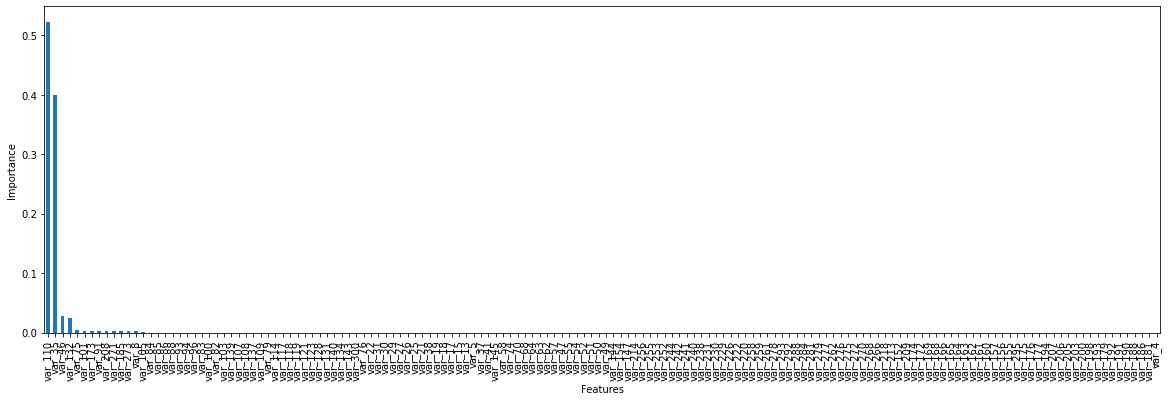

In [9]:
# importance of all features based of initial model

rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

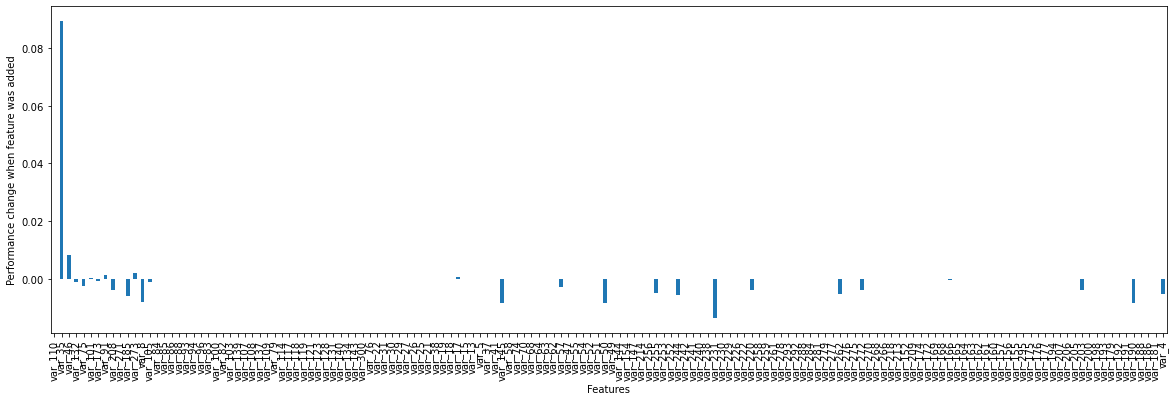

In [10]:
pd.Series(rfa.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

Very few features cause a big increase in model performance when added.

In [11]:
# Number of features that will be removed

len(rfa.features_to_drop_)

145

In [12]:
# select features

X_train = rfa.transform(X_train)
X_test = rfa.transform(X_test)

In [13]:
# now for comparison, we build a model with the selected features only

model_final = GradientBoostingClassifier(
    n_estimators=10, max_depth=2, random_state=10)

# fit the model with the selected features
model_final.fit(X_train, y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test)[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.802329


The ROC-AUC is very similar to that of the model trained using all the variables.

## Regression

In [14]:
# load dataset

data = pd.read_csv('../houseprice.csv')
data.shape

(1460, 81)

In [15]:
# for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [16]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [17]:
# fill missing values

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Recursive Feature Addition

In [18]:
# the model for which we want to select features
model = GradientBoostingRegressor(
    n_estimators=10, max_depth=4, random_state=10)


# Setup the RFA selector
rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='r2',  # the metric we want to evalute
    threshold=0.001,  # the minimum performance increase needed to select a feature
    cv=2,  # cross-validation
)

rfa.fit(X_train, y_train)

RecursiveFeatureAddition(cv=2,
                         estimator=GradientBoostingRegressor(alpha=0.9,
                                                             ccp_alpha=0.0,
                                                             criterion='friedman_mse',
                                                             init=None,
                                                             learning_rate=0.1,
                                                             loss='ls',
                                                             max_depth=4,
                                                             max_features=None,
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                   

In [19]:
# performance of model trained using all features

rfa.initial_model_performance_

0.6821660665052749

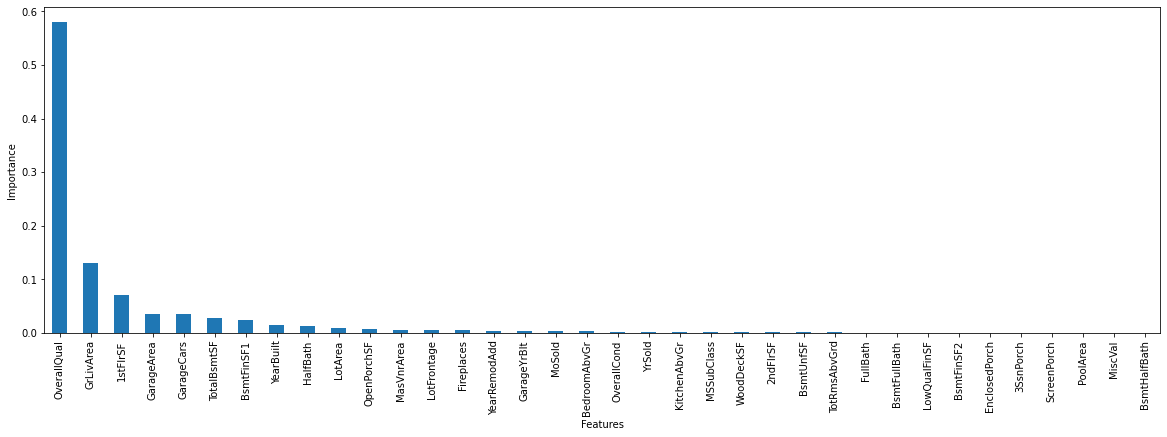

In [20]:
# importance of all features based of initial model

rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

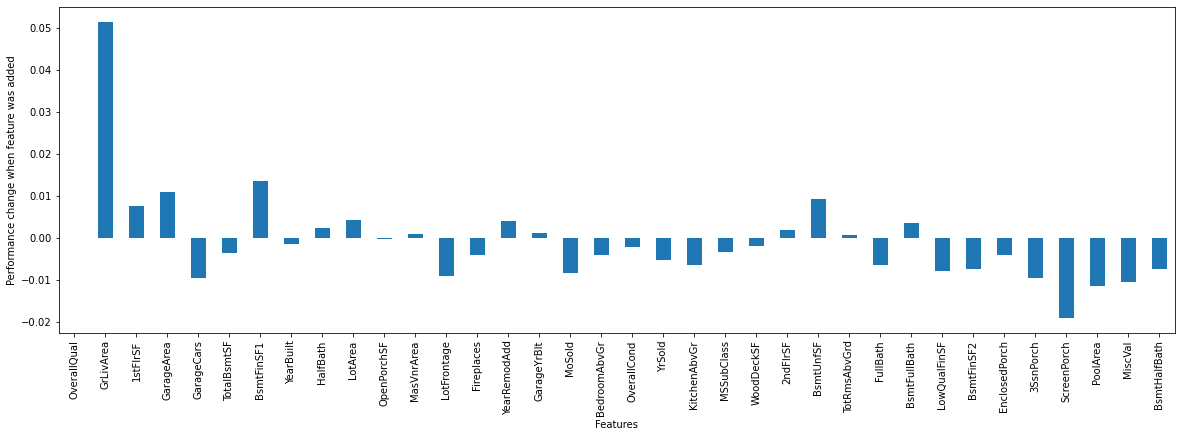

In [21]:
pd.Series(rfa.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [22]:
# Number of features that will be removed

len(rfa.features_to_drop_)

24

In [23]:
X_train = rfa.transform(X_train)
X_test = rfa.transform(X_test)

X_train.shape, X_test.shape

((1022, 12), (438, 12))

In [24]:
# finally let's test the performance of the model 
# built on the selected features

# build initial model
model_final = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train, y_train)

# make predictions
y_pred_test = model_final.predict(X_test)

# calculate roc-auc
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_final))

Test selected features r2 = 0.735100


The model trained using less features shows a similar performance to the original one.

That is all for this lecture, I hope you enjoyed it and see you in the next one!